In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt

In [4]:
image1 = cv.imread("../Data/House/frame00000001.png")
image2 = cv.imread("../Data/House/frame00000049.png")

In [101]:
from fundamental_matrix import keypoint_matcher, get_fundamental_matrix, draw_epipolar_lines

Before filtering neighbours: 543. After: 154


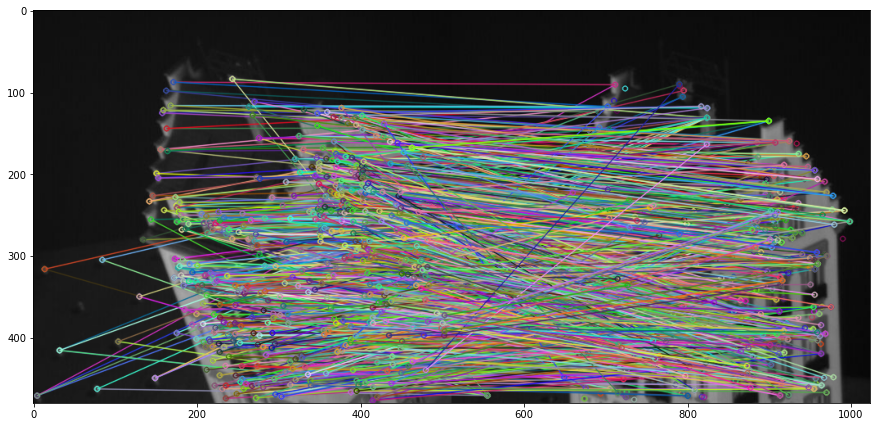

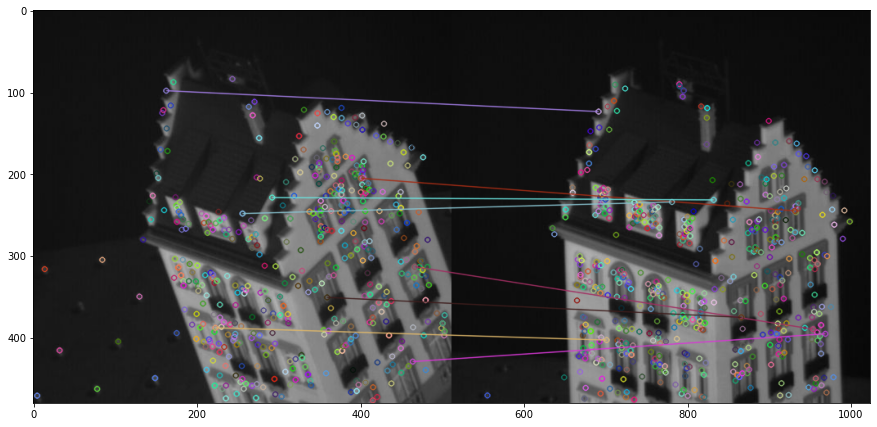

In [102]:
matches, matched_points1, matched_points2, kp1, kp2 = keypoint_matcher(image1, image2,
                                                                       random_n=8,
                                                                       filter_neighbours=True,
                                                                       draw_matches=True)

In [103]:
F = get_fundamental_matrix(matched_points1, matched_points2)

U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 3.79015478e-04 -1.29107699e-03  2.25317487e-01  1.37631871e-03
 -6.65414001e-04 -3.76501427e-01 -5.10446088e-01  7.32715258e-01
 -1.00238216e-01]
(9,)
F
[[ 3.79015478e-04 -1.29107699e-03  2.25317487e-01]
 [ 1.37631871e-03 -6.65414001e-04 -3.76501427e-01]
 [-5.10446088e-01  7.32715258e-01 -1.00238216e-01]]
(3, 3)
FD_prime [9.00303219e-01 4.35263269e-01 1.77918737e-05]
FD_prime with the smallest singular value zeroed [0.90030322 0.43526327 0.        ]


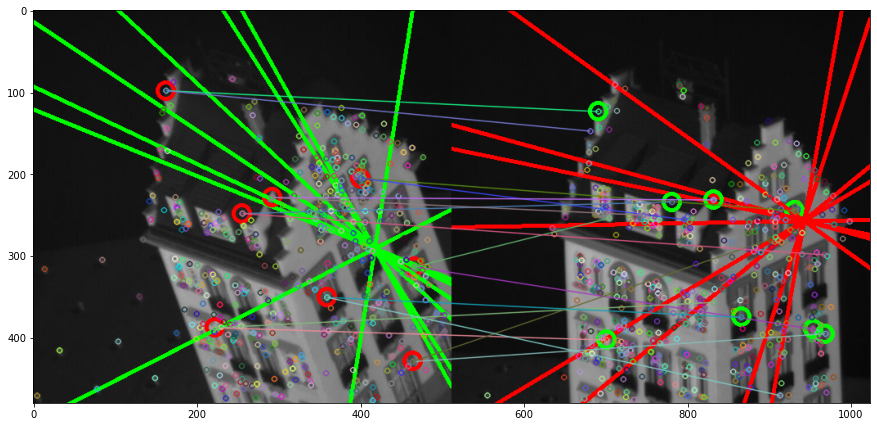

In [105]:
draw_epipolar_lines(image1, image2, matches, kp1, kp2, F)